# Air Quality Data analysis

Here, I have plotted and analysed the satellite-derived PM2.5 data for India. The data has a resolution of $0.1\degree \times 0.1\degree$. The dataset that I have used is provided by the [Atmospheric Composition Analysis Group](https://sites.wustl.edu/acag/datasets/surface-pm2-5/) and 
is available here: https://wustl.app.box.com/v/ACAG-V5GL04-GWRPM25c0p10/folder/237168822060

#### Import Libraries

In [2]:
import numpy as np
import netCDF4
import reverse_geocode
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from joblib import Parallel, delayed 
import multiprocessing
import pandas as pd
import datetime

#### Constants

In [3]:
Timestamp_Start = 1998 * 12
Timepoints = 300
Timestamp_End = Timestamp_Start + Timepoints

#### Functions

In [6]:
def getYearMonth(timestamp):
  return int(timestamp / 12), (timestamp % 12 + 1)

def getAsiaPM25Filename(timestamp):
  year, month = getYearMonth(timestamp)
  month = str(month).zfill(2)
  return f'monthly/V5GL04.HybridPM25c_0p10.Asia.{year}{month}-{year}{month}.nc'

def getNorthAmericaPM25Filename(timestamp):
  year, month = getYearMonth(timestamp)
  month = str(month).zfill(2)
  return f'PM25 data/Monthly/V5GL04.HybridPM25c_0p10.NorthAmerica.{year}{month}-{year}{month}.nc'

def getIndiaPM25Filename(timestamp):
  year, month = getYearMonth(timestamp)
  month = str(month).zfill(2)
  return f'formatted_monthly/PM2.5_India.{year}{month}.nc'

def getAsiaPM25Data(timestamp):
  fileName = getAsiaPM25Filename(timestamp)
  ncFile = netCDF4.Dataset(fileName)
  data = np.array(ncFile.variables['lat']), np.array(ncFile.variables['lon']), ncFile.variables["GWRPM25"][:, :]
  ncFile.close()
  return data

def getIndiaPM25Data(timestamp):
  fileName = getIndiaPM25Filename(timestamp)
  ncFile = netCDF4.Dataset(fileName)
  data = np.array(ncFile.variables['lat']), np.array(ncFile.variables['lon']), ncFile.variables['GWRPM25'][:, :]
  ncFile.close()
  return data

def getNorthAmericaPM25Data(timestamp):
  fileName = getNorthAmericaPM25Filename(timestamp)
  ncFile = netCDF4.Dataset(fileName)
  data = np.array(ncFile.variables['lat']), np.array(ncFile.variables['lon']), ncFile.variables['GWRPM25'][:, :]
  ncFile.close()
  return data

## PM2.5 Data Analysis

### Preparing the dataset

While the provided data encompasses all of Asia, here I'm specifically extracting information relevant to India.  I use the `reverse_geocode` library to check if a given cell lies in India after trimming the dataset. However, this still takes a lot of time to compute, so I have saved all the data in the `formatted_monthly` directory. 

In [ ]:
# This will return the lat and lon of the initial coordintes
def getAsiaLatLon():
    data = getAsiaPM25Data(Timestamp_Start)
    return data[0], data[1]

lat, lon = getAsiaLatLon()

lat_mask = (lat > 8.06666667) & (lat < 37.1) # latitude of India
lon_mask = (lon > 68.1166667) & (lon < 97.4166667) # longitude of India

lat = lat[lat_mask]
lon = lon[lon_mask]

def readAndFormatData(fileIdx):
    data = getAsiaPM25Data(fileIdx + Timestamp_Start)[2][lat_mask, :][:, lon_mask]
    for i, _lat in enumerate(lat):
        for j, _lon in enumerate(lon):
            coords = (_lat, _lon),
            obj = reverse_geocode.search(coords)
            if obj[0]['country'] != 'India':
                data[i][j] = np.nan

    return data

def saveDataToFile(timestamp, pm25):
    ncfile = netCDF4.Dataset(getIndiaPM25Filename(timestamp), mode='w', format='NETCDF4_CLASSIC')
    
    lat_dim = ncfile.createDimension('lat', len(lat))     # latitude axis
    lon_dim = ncfile.createDimension('lon', len(lon))    # longitude axis
    
    lat_var = ncfile.createVariable('lat', np.float64, ('lat',))
    lat_var.units = 'degrees_north'
    lat_var.long_name = 'latitude'
    
    lon_var = ncfile.createVariable('lon', np.float64, ('lon',))
    lon_var.units = 'degrees_east'
    lon_var.long_name = 'longitude'
    
    GWRPM25 = ncfile.createVariable('GWRPM25', np.float32, ('lat','lon')) 
    
    lat_var[:] = lat
    lon_var[:] = lon
    GWRPM25[:,:] = pm25
    
    ncfile.close()

def formatFile(fileNumber):
    print(f"Writing file {fileNumber}")
    saveDataToFile(fileNumber + Timestamp_Start, readAndFormatData(fileNumber))
    
Parallel(n_jobs=-1)(delayed(formatFile) (i) for i in range(Timepoints)) 

print("Done!")

### Video Animation of the Air quality snapshots
Here is a video animation of the air quality snapshots of India over the time period of 1998-2022. Here, I have used the non-formatted data. However, to use the formatted data, you can change the directory of the variable `fp` from `monthly` to `monthly_formatted` at the two places.

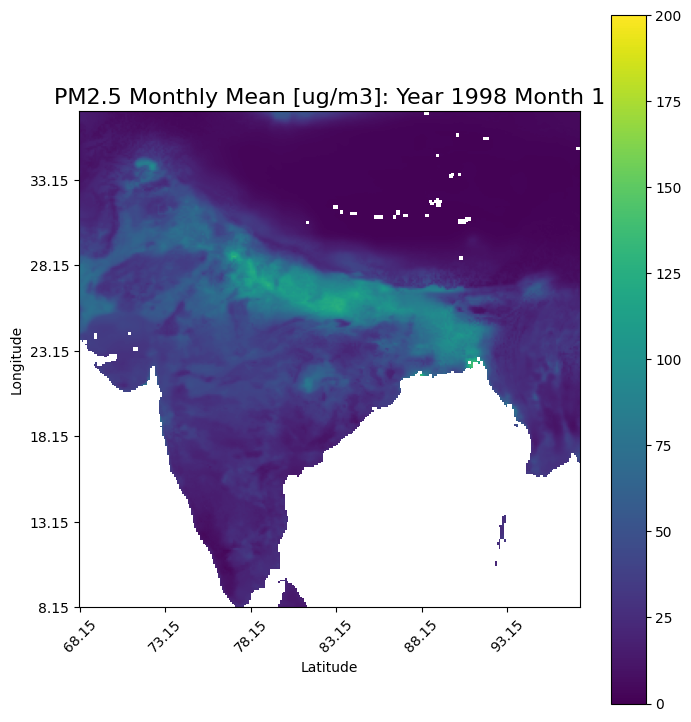

In [7]:
%matplotlib tk

scale = 1/40
frames = 300
interval = 100

lat, lon, data = getAsiaPM25Data(Timestamp_Start)

lat = np.round(lat, 2)
lon = np.round(lon, 2)

lat_mask = (lat > 8.06666667) & (lat < 37.1) # latitude of india
lon_mask = (lon > 68.1166667) & (lon < 97.4166667) # longitude of india

lat_step_size = 50
lon_step_size = 50

lat = lat[lat_mask]
lon = lon[lon_mask]
data = data[lat_mask, :][:, lon_mask]

fig = plt.figure(figsize=(data.shape[0]*scale, data.shape[1]*scale))
im = plt.imshow(data, vmin=0, vmax=200)

plt.ylim(bottom=0, top=len(data))
plt.yticks(np.arange(0, data.shape[0], lat_step_size), labels=lat[::lat_step_size])
plt.xticks(np.arange(0, data.shape[1], lon_step_size), labels=lon[::lon_step_size], rotation=45)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title(f"PM2.5 Monthly Mean [ug/m3]: Year {1998} Month {1}", fontsize=16)
plt.colorbar()
plt.tight_layout()

def animation_fn(frame):
    year, month = getYearMonth(Timestamp_Start + frame)
    im.set_array(getAsiaPM25Data(frame + Timestamp_Start)[2][lat_mask, :][:,  lon_mask])
    im.axes.set_title(f"PM2.5 Monthly Mean [ug/m3]: Year {year} Month {int(month)}", fontsize=16)
    
    return [im]

anim = animation.FuncAnimation(fig, animation_fn, frames=frames, interval=interval)
plt.show()

### Monthly Average PM2.5 in India
The graph below shows the monthly average PM2.5 in India. It has a periodic nature.

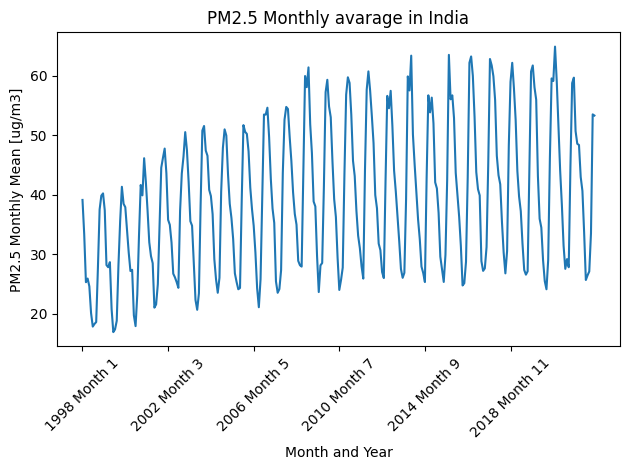

In [ ]:
# Average of India for all the months
step_size = 50
monthly_average = []
num_years = 25

for i in range(300):
    avg = np.nanmean(getIndiaPM25Data(Timestamp_Start + i)[2])
    monthly_average.append(avg)

def get_label_string(frame):
    return f"{1998 + int(frame/12)} Month {frame % 12 + 1}"

plt.plot(monthly_average)
plt.xticks(np.arange(0, num_years * 12, step_size), labels=[get_label_string(frame) for frame in range(0, num_years * 12, step_size)], rotation=45)
plt.title("PM2.5 Monthly avarage in India")
plt.ylabel("PM2.5 Monthly Mean [ug/m3]")
plt.xlabel("Month and Year")
plt.tight_layout()
plt.show()

### Yearly average PM2.5 in India
As you can see from below the yearly PM2.5 average.

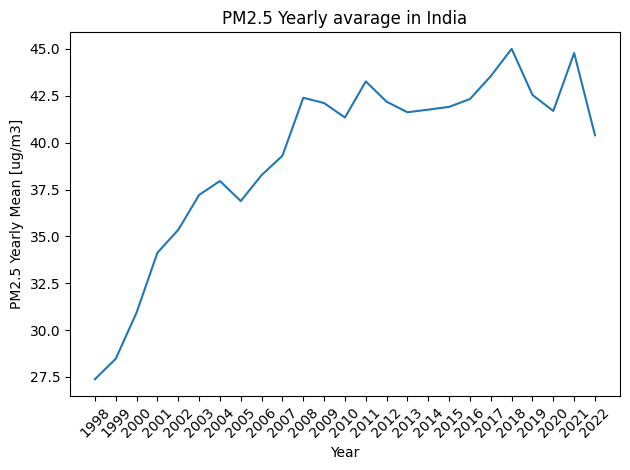

In [ ]:
step_size = 1
yearly_average = [np.mean(monthly_average[i:i+12]) for i in range(0, num_years * 12, 12)]
plt.plot(yearly_average)
plt.xticks(np.arange(0, len(yearly_average), step_size), labels=[f"{1998 + frame}" for frame in range(0, len(yearly_average), step_size)], rotation=45)
plt.title("PM2.5 Yearly avarage in India")
plt.ylabel("PM2.5 Yearly Mean [ug/m3]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

### Monthly average over the years
As you can see from the plot below the PM2.5 data is at the minimum in around Augest and reaches the maximum in around January and December 

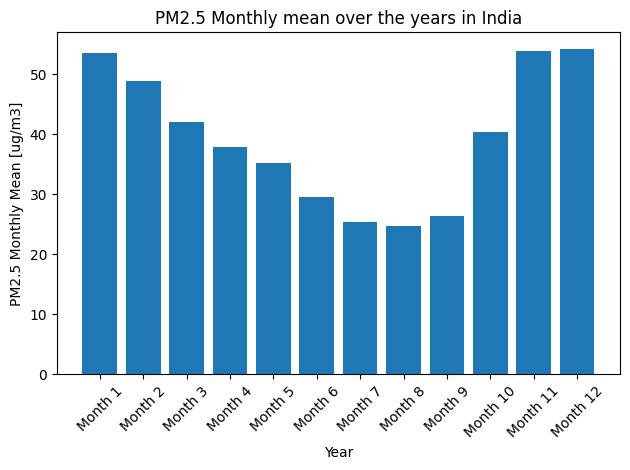

In [ ]:
monthly_av_over_years = [np.mean(monthly_average[i::12]) for i in range(12)]
plt.bar([f"Month {frame + 1}" for frame in range(0, 12)], monthly_av_over_years)
plt.xticks(np.arange(0, 12, step_size), rotation=45)
plt.title("PM2.5 Monthly mean over the years in India")
plt.ylabel("PM2.5 Monthly Mean [ug/m3]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

### Yearly Standard deviation of PM2.5 in India

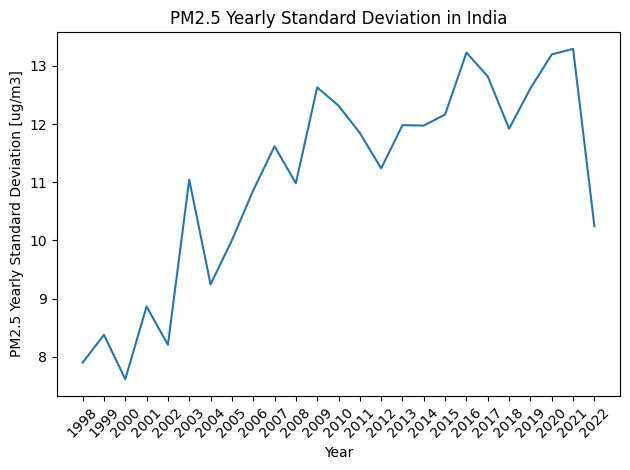

In [ ]:
num_years = 25
yearly_sd = [np.std(monthly_average[i:i+12]) for i in range(0, num_years * 12, 12)]
plt.figure()
plt.plot(yearly_sd)
plt.xticks(np.arange(0, num_years, step_size), labels=[f"{1998 + frame}" for frame in range(0, num_years, step_size)], rotation=45)
plt.title("PM2.5 Yearly Standard Deviation in India")
plt.ylabel("PM2.5 Yearly Standard Deviation [ug/m3]")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

## Prediction PM2.5 using ML Algorithms

### Predicting PM2.5 with time using Regression

In [5]:
def print_error(err):
    df = pd.DataFrame([[f'Year {int(i/12) + 1998}, Month {i % 12 + 1}', elt] for i, elt in enumerate(err)], columns=["Time", "Error"])
    print(df.to_markdown())

def plot_error(err, title, ylabel, step_size=50):
    plt.figure()
    plt.plot(err)
    plt.xticks(np.arange(0, len(err), step_size), labels=[f"{1998 + int(frame / 12)} Month {frame % 12 + 1}" for frame in range(0, len(err), step_size)], rotation=45)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Year and Month")
    plt.tight_layout()
    plt.show()

#### Linear Regression
Here I have performed a regression over the monthly snapshot of India. However this doesn't give good results, because of the periodic nature of PM2.5 in India. Hence I have also performed a regression for each month seperatly.

In [ ]:
all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]

error_linear_regression = np.zeros(300)
cnt = 0



def train_and_compute_error(i, j):
    if np.isnan(all_data[0, i, j]):
        return
    global cnt
    cnt += 1
    current_data = (np.array(list(enumerate(all_data[:, i, j]))))
    training_data_length = int(len(current_data) * 0.2)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    y = [[a] for a in (current_data[:training_data_length, 1])]
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_linear_regression
    error_linear_regression += ((predictions - current_data[:, 1]) ** 2)
    
Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(i, j) for i in range(len(lat)) for j in range(len(lon)))
error_linear_regression /= cnt
error_linear_regression = np.sqrt(error_linear_regression)
print_error(error_linear_regression)

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  | 18.8846  |
|   1 | Year 1998, Month 2  | 10.4662  |
|   2 | Year 1998, Month 3  |  7.46604 |
|   3 | Year 1998, Month 4  |  6.3853  |
|   4 | Year 1998, Month 5  |  6.39752 |
|   5 | Year 1998, Month 6  | 11.486   |
|   6 | Year 1998, Month 7  | 13.8018  |
|   7 | Year 1998, Month 8  | 13.9136  |
|   8 | Year 1998, Month 9  | 13.7579  |
|   9 | Year 1998, Month 10 |  7.33568 |
|  10 | Year 1998, Month 11 | 18.3435  |
|  11 | Year 1998, Month 12 | 22.3858  |
|  12 | Year 1999, Month 1  | 19.7591  |
|  13 | Year 1999, Month 2  | 14.4864  |
|  14 | Year 1999, Month 3  | 11.937   |
|  15 | Year 1999, Month 4  |  7.47221 |
|  16 | Year 1999, Month 5  |  8.77492 |
|  17 | Year 1999, Month 6  | 13.7959  |
|  18 | Year 1999, Month 7  | 15.9227  |
|  19 | Year 1999, Month 8  | 16.0719  |
|  20 | Year 1999, Month 9  | 15.0139  |
|  21 | Year 1999, Month 10 |  8.76216 |
|  22 | Year 199

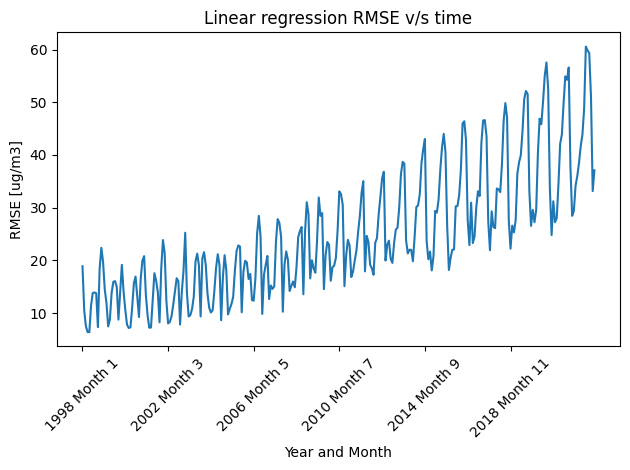

In [ ]:
plot_error(error_linear_regression, "Linear regression RMSE v/s time", "RMSE [ug/m3]")

#### Linear Regression (Monthly)
Since PM2.5 in India is somewhat periodic, I though of sampling data from each month for a region and then doing linear regression on that, the results come out to be better than the normal Linear Regression, However I had to train on 50% of the data. Here rergession is done only on top $12\degree$ latitudes of India.

In [ ]:
all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
error_linear_regression_monthly = np.zeros(300)
cnt = 0

max_lat = 100

# 346188
def train_and_compute_error(month, i, j):
    if np.isnan(all_data[month, i, j]):
        return
    global cnt
    cnt += 1
    unshuffled_data = (np.array(list(enumerate(all_data[month::12, i, j]))))
    current_data = (np.array(list(enumerate(all_data[month::12, i, j]))))
    training_data_length = int(len(current_data) * 0.5)
    np.random.shuffle(current_data)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    y = [[a] for a in (current_data[:training_data_length, 1])]
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_linear_regression_monthly
    for i, e in enumerate(((predictions - unshuffled_data[:, 1]) ** 2)):
        error_linear_regression_monthly[12 * i + month] += e

# Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(month, i, j) for i in range(len(lat)) for j in range(len(lon)) for month in range(12))
Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(month, i, j) for i in range(max_lat) for j in range(len(lon)) for month in range(12))
error_linear_regression_monthly /= cnt/12
error_linear_regression_monthly = np.sqrt(error_linear_regression_monthly)
print_error(error_linear_regression_monthly)

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  |  7.30463 |
|   1 | Year 1998, Month 2  |  7.70297 |
|   2 | Year 1998, Month 3  |  9.39387 |
|   3 | Year 1998, Month 4  |  7.19716 |
|   4 | Year 1998, Month 5  |  4.02424 |
|   5 | Year 1998, Month 6  |  2.72531 |
|   6 | Year 1998, Month 7  |  3.19412 |
|   7 | Year 1998, Month 8  |  3.43827 |
|   8 | Year 1998, Month 9  |  4.79356 |
|   9 | Year 1998, Month 10 |  8.03379 |
|  10 | Year 1998, Month 11 |  9.35237 |
|  11 | Year 1998, Month 12 |  5.29437 |
|  12 | Year 1999, Month 1  |  4.63903 |
|  13 | Year 1999, Month 2  |  5.57666 |
|  14 | Year 1999, Month 3  |  5.14332 |
|  15 | Year 1999, Month 4  |  5.71006 |
|  16 | Year 1999, Month 5  |  3.67547 |
|  17 | Year 1999, Month 6  |  2.94355 |
|  18 | Year 1999, Month 7  |  4.54508 |
|  19 | Year 1999, Month 8  |  3.96806 |
|  20 | Year 1999, Month 9  |  5.36793 |
|  21 | Year 1999, Month 10 |  9.4555  |
|  22 | Year 199

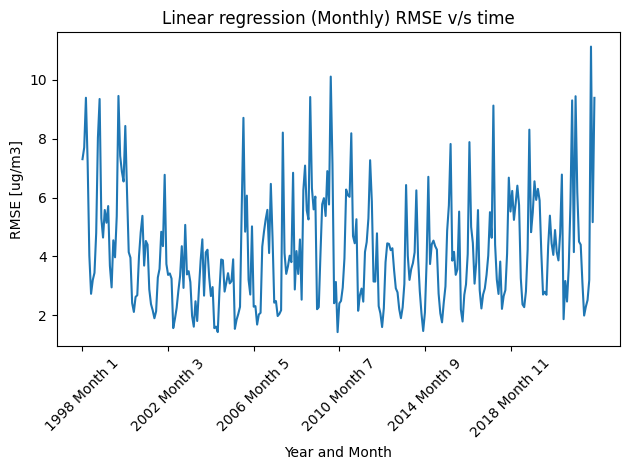

In [ ]:
plot_error(error_linear_regression_monthly, "Linear regression (Monthly) RMSE v/s time", "RMSE [ug/m3]")

#### Random Forest
Here I try to predict PM2.5 using the Random Forest Algorithm. I have done regression only on 500 grids of India of area $0.1\degree \times 0.1\degree$

In [ ]:
all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
error_random_forest = np.zeros(300)
cnt = 0

max_grids = 500

def train_and_compute_error(i, j):
    if np.isnan(all_data[0, i, j]):
        return
    global cnt
    if cnt > max_grids:
        return
    cnt += 1
    unshuffled_data = (np.array(list(enumerate(all_data[:, i, j]))))
    current_data = (np.array(list(enumerate(all_data[:, i, j]))))
    training_data_length = int(len(current_data))
    np.random.shuffle(current_data)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    reg = RandomForestRegressor(n_estimators=20, max_depth=8, random_state=0).fit(X, current_data[:training_data_length, 1])
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_random_forest
    error_random_forest += ((predictions - unshuffled_data[:, 1]) ** 2)

Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(i, j) for i in range(len(lat)) for j in range(len(lon)))
error_random_forest /= cnt
error_random_forest = np.sqrt(error_random_forest)
print_error(error_random_forest)

|     | Time                |     Error |
|----:|:--------------------|----------:|
|   0 | Year 1998, Month 1  |  1.57045  |
|   1 | Year 1998, Month 2  |  2.09854  |
|   2 | Year 1998, Month 3  |  1.5508   |
|   3 | Year 1998, Month 4  |  2.68953  |
|   4 | Year 1998, Month 5  |  1.12141  |
|   5 | Year 1998, Month 6  |  1.30646  |
|   6 | Year 1998, Month 7  |  0.498576 |
|   7 | Year 1998, Month 8  |  0.605861 |
|   8 | Year 1998, Month 9  |  0.903587 |
|   9 | Year 1998, Month 10 |  1.55038  |
|  10 | Year 1998, Month 11 |  1.7602   |
|  11 | Year 1998, Month 12 |  2.19203  |
|  12 | Year 1999, Month 1  |  3.16138  |
|  13 | Year 1999, Month 2  |  1.94765  |
|  14 | Year 1999, Month 3  |  1.82008  |
|  15 | Year 1999, Month 4  |  2.31101  |
|  16 | Year 1999, Month 5  |  2.6327   |
|  17 | Year 1999, Month 6  |  1.50052  |
|  18 | Year 1999, Month 7  |  0.764445 |
|  19 | Year 1999, Month 8  |  0.697819 |
|  20 | Year 1999, Month 9  |  1.2097   |
|  21 | Year 1999, Month 10 |  2.2

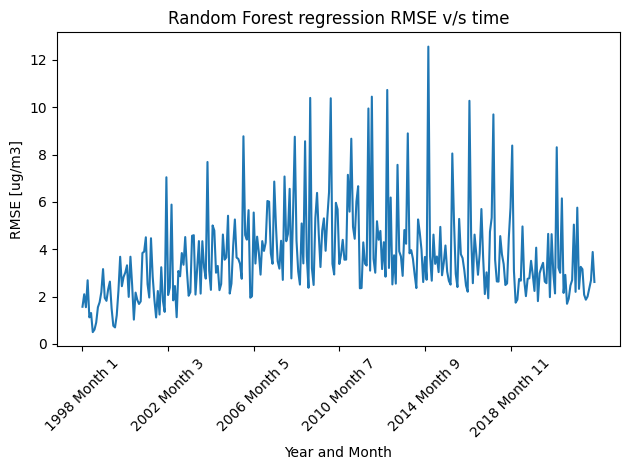

In [ ]:
plot_error(error_random_forest, "Random Forest regression RMSE v/s time", "RMSE [ug/m3]")

#### K nearest neighbors

In [ ]:
all_data = np.array([netCDF4.Dataset(f"formatted_monthly/{i}.nc")["GWRPM25"] for i in range(300)])
lat = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lat"]
lon = netCDF4.Dataset(f"formatted_monthly/{0}.nc")["lon"]

error_knn = np.zeros(300)
cnt = 0
def train_and_compute_error(i, j):
    if np.isnan(all_data[0, i, j]):
        return
    global cnt
    cnt += 1
    # if cnt > max_grids:
    #     return
    unshuffled_data = (np.array(list(enumerate(all_data[:, i, j]))))
    current_data = (np.array(list(enumerate(all_data[:, i, j]))))
    training_data_length = int(len(current_data) * 0.2)
    np.random.shuffle(current_data)
    X = [[a] for a in (current_data[:training_data_length, 0])]
    y = [[a] for a in (current_data[:training_data_length, 1])]
    reg = KNeighborsRegressor(n_neighbors=2).fit(X, y)
    predictions = reg.predict([[data_point] for data_point in np.arange(len(current_data))]).flatten()
    global error_knn
    error_knn += ((predictions - unshuffled_data[:, 1]) ** 2)

Parallel(n_jobs=multiprocessing.cpu_count(), require='sharedmem')(delayed(train_and_compute_error)(i, j) for i in range(len(lat)) for j in range(len(lon)))
error_knn /= cnt
error_knn = np.sqrt(error_knn)
print_error(error_knn)

|     | Time                |   Error |
|----:|:--------------------|--------:|
|   0 | Year 1998, Month 1  | 19.7137 |
|   1 | Year 1998, Month 2  | 13.1014 |
|   2 | Year 1998, Month 3  | 11.7324 |
|   3 | Year 1998, Month 4  | 10.6554 |
|   4 | Year 1998, Month 5  | 10.594  |
|   5 | Year 1998, Month 6  | 13.1368 |
|   6 | Year 1998, Month 7  | 15.0099 |
|   7 | Year 1998, Month 8  | 15.6987 |
|   8 | Year 1998, Month 9  | 16.521  |
|   9 | Year 1998, Month 10 | 11.8068 |
|  10 | Year 1998, Month 11 | 19.3206 |
|  11 | Year 1998, Month 12 | 22.6129 |
|  12 | Year 1999, Month 1  | 20.4177 |
|  13 | Year 1999, Month 2  | 16.8956 |
|  14 | Year 1999, Month 3  | 15.4441 |
|  15 | Year 1999, Month 4  | 11.9933 |
|  16 | Year 1999, Month 5  | 12.6046 |
|  17 | Year 1999, Month 6  | 15.1333 |
|  18 | Year 1999, Month 7  | 16.5036 |
|  19 | Year 1999, Month 8  | 16.8843 |
|  20 | Year 1999, Month 9  | 16.4464 |
|  21 | Year 1999, Month 10 | 12.4744 |
|  22 | Year 1999, Month 11 | 16.3501 |


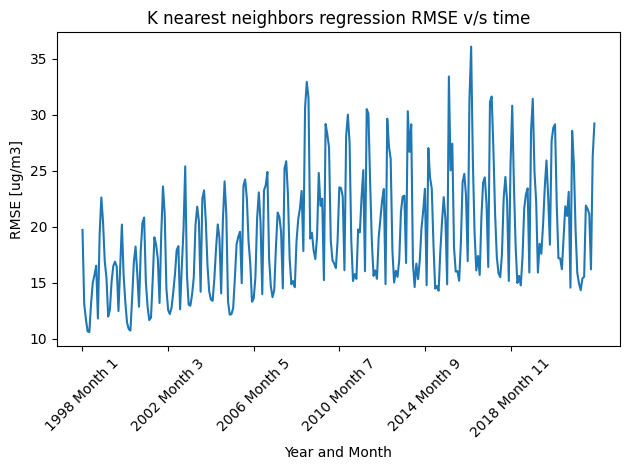

In [ ]:
plot_error(error_knn, "K nearest neighbors regression RMSE v/s time", "RMSE [ug/m3]")

#### Final Results - Comparing various algorithms

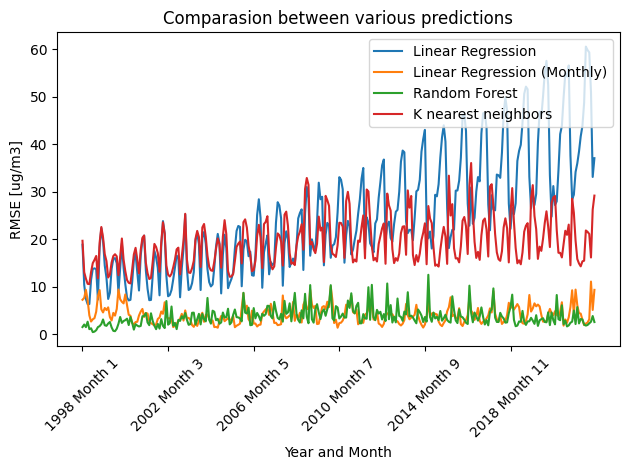

In [ ]:
plt.figure()
[lr, lrm, rf, knn] = plt.plot(np.transpose([error_linear_regression, error_linear_regression_monthly, error_random_forest, error_knn]))
plt.legend([lr, lrm, rf, knn], ["Linear Regression", "Linear Regression (Monthly)", "Random Forest", "K nearest neighbors"], loc=1)
plt.xticks(np.arange(0, len(error_linear_regression), step_size), labels=[f"{1998 + int(frame / 12)} Month {frame % 12 + 1}" for frame in range(0, len(error_linear_regression), step_size)], rotation=45)
plt.title("Comparasion between various algorithms")
plt.ylabel("RMSE [ug/m3]")
plt.xlabel("Year and Month")
plt.tight_layout()
plt.show()

### Spatial Prediction of PM2.5 using Regression

Test and train data:
Here I have taken 40% of the points for training the model and the remaining for testing.

In [4]:
all_data = np.array([getIndiaPM25Data(i + Timestamp_Start)[2] for i in range(Timepoints)])
lat, lon = getIndiaPM25Data(Timestamp_Start)[:2]
step_size = 1

X_train = []
X_test = []
y_train = []
y_test = []

for frame in range(Timepoints):
    current_data = np.array([[_lat, _lon, all_data[frame, i, j]] for i, _lat in enumerate(lat) for j, _lon in enumerate(lon)])
    current_data = current_data[~np.isnan(current_data[:, 2])]
    training_data_length = int(len(current_data) * 0.4)
    
    selected_train_points = np.random.choice(len(current_data), training_data_length)
    training_data = current_data[selected_train_points]

    selected_test_points = np.ones(len(current_data), dtype=bool)
    selected_test_points[selected_train_points] = False
    testing_data = current_data[selected_test_points]

    X_train.append(training_data[:, :2])
    y_train.append(training_data[:, 2])
    
    # Take all the other points
    X_test.append(testing_data[:, :2])
    y_test.append(testing_data[:, 2])



#### Linear regerssion

In [5]:
error_linear_regression = np.zeros(300)

def train_and_compute_error(frame):
    X = X_train[frame]
    y = y_train[frame]
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict(X_test[frame])
    print(reg.coef_, predictions)
    return np.sqrt(np.mean((predictions - y_test[frame]) ** 2))
    
for i in range(Timepoints):
    error_linear_regression[i] = train_and_compute_error(i)

[ 1.25080358 -0.04314961] [20.86678084 20.86246595 20.85815106 ... 56.28609725 56.27746746
 56.41549092]
[0.46776061 0.06780715] [26.01908636 26.02586749 26.03942871 ... 39.24315046 39.26958346
 39.2831452 ]
[0.19607785 0.01801692] [22.29648679 22.30009012 22.30189178 ... 27.84008492 27.84188659
 27.85428728]
[ 0.9418802  -0.27720262] [12.85686628 12.82914432 12.74598481 ... 39.53979602 39.74486407
 39.68942228]
[ 1.14482326 -0.56160588] [ 9.29959072  9.24343099  9.18727126 ... 42.14953678 42.09337276
 42.03721303]
[ 0.80618956 -0.74906564] [10.19964473 10.04982817  9.97492275 ... 33.46995999 33.39504886
 33.32014344]
[ 0.61213291 -0.76008322] [10.89499225 10.81898509 10.74297793 ... 28.52238808 28.37037375
 28.58360043]
[ 0.56405029 -0.77937231] [12.20041471 12.12247867 12.04454263 ... 28.6870702  28.60912821
 28.53119217]
[ 0.36737403 -0.51133136] [14.67772068 14.62658442 14.57545207 ... 25.12553815 25.31567206
 25.26453971]
[ 1.11647285 -0.75401804] [13.13549987 13.06009922 12.90929

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  | 23.1861  |
|   1 | Year 1998, Month 2  | 16.6823  |
|   2 | Year 1998, Month 3  | 10.9182  |
|   3 | Year 1998, Month 4  | 13.7455  |
|   4 | Year 1998, Month 5  | 13.1237  |
|   5 | Year 1998, Month 6  | 11.4447  |
|   6 | Year 1998, Month 7  |  9.00201 |
|   7 | Year 1998, Month 8  |  9.51136 |
|   8 | Year 1998, Month 9  |  8.32448 |
|   9 | Year 1998, Month 10 | 15.3762  |
|  10 | Year 1998, Month 11 | 25.3988  |
|  11 | Year 1998, Month 12 | 28.359   |
|  12 | Year 1999, Month 1  | 25.4223  |
|  13 | Year 1999, Month 2  | 15.8777  |
|  14 | Year 1999, Month 3  | 12.174   |
|  15 | Year 1999, Month 4  | 14.3664  |
|  16 | Year 1999, Month 5  | 15.7808  |
|  17 | Year 1999, Month 6  | 13.548   |
|  18 | Year 1999, Month 7  |  9.12503 |
|  19 | Year 1999, Month 8  |  8.36968 |
|  20 | Year 1999, Month 9  |  7.87288 |
|  21 | Year 1999, Month 10 | 15.4509  |
|  22 | Year 199

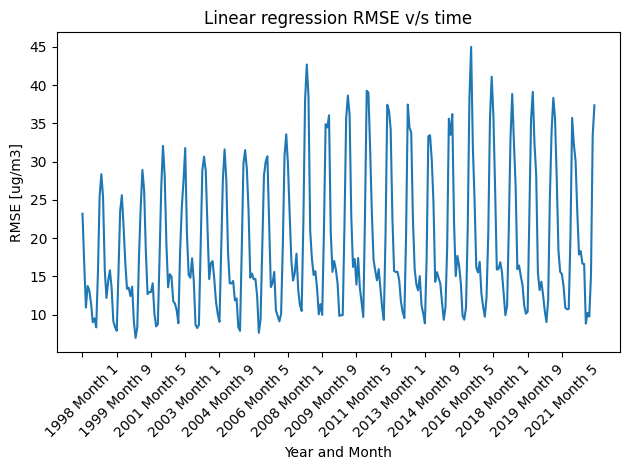

In [8]:
print_error(error_linear_regression)
plot_error(error_linear_regression, "Linear regression RMSE v/s time", "RMSE [ug/m3]", step_size=20)

#### Random forest

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  |  8.44052 |
|   1 | Year 1998, Month 2  |  6.85691 |
|   2 | Year 1998, Month 3  |  5.52178 |
|   3 | Year 1998, Month 4  |  5.54619 |
|   4 | Year 1998, Month 5  |  5.02241 |
|   5 | Year 1998, Month 6  |  3.85779 |
|   6 | Year 1998, Month 7  |  3.01177 |
|   7 | Year 1998, Month 8  |  2.96332 |
|   8 | Year 1998, Month 9  |  3.26494 |
|   9 | Year 1998, Month 10 |  5.71873 |
|  10 | Year 1998, Month 11 |  9.03309 |
|  11 | Year 1998, Month 12 |  9.94526 |
|  12 | Year 1999, Month 1  |  9.87595 |
|  13 | Year 1999, Month 2  |  7.65139 |
|  14 | Year 1999, Month 3  |  4.92524 |
|  15 | Year 1999, Month 4  |  5.048   |
|  16 | Year 1999, Month 5  |  5.04845 |
|  17 | Year 1999, Month 6  |  3.73075 |
|  18 | Year 1999, Month 7  |  2.81363 |
|  19 | Year 1999, Month 8  |  3.22969 |
|  20 | Year 1999, Month 9  |  3.24622 |
|  21 | Year 1999, Month 10 |  5.86689 |
|  22 | Year 199

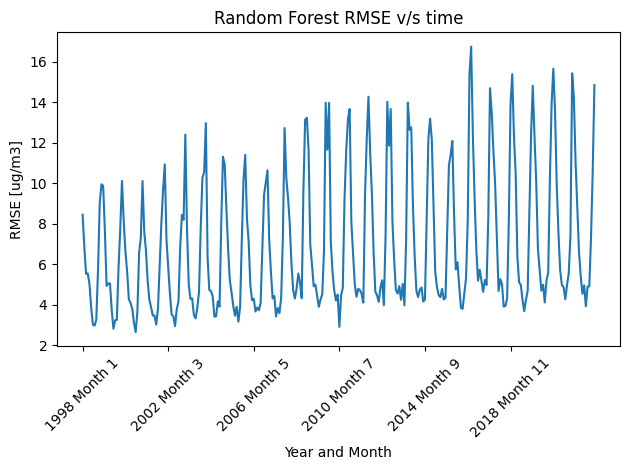

In [9]:
error_random_forest = np.zeros(300)

def train_and_compute_error(frame):
    X = X_train[frame]
    y = y_train[frame]
    reg = RandomForestRegressor(n_estimators=20, max_depth=8, random_state=0).fit(X, y)
    predictions = reg.predict(X_test[frame])

    return np.sqrt(np.mean((predictions - y_test[frame]) ** 2))
    
for i in range(Timepoints):
    error_random_forest[i] = train_and_compute_error(i)

print_error(error_random_forest)
plot_error(error_random_forest, "Random Forest RMSE v/s time", "RMSE [ug/m3]", 20)

#### K Nearest Neighbours

|     | Time                |    Error |
|----:|:--------------------|---------:|
|   0 | Year 1998, Month 1  | 3.15902  |
|   1 | Year 1998, Month 2  | 2.93248  |
|   2 | Year 1998, Month 3  | 2.4754   |
|   3 | Year 1998, Month 4  | 2.11468  |
|   4 | Year 1998, Month 5  | 1.98093  |
|   5 | Year 1998, Month 6  | 1.45903  |
|   6 | Year 1998, Month 7  | 1.0355   |
|   7 | Year 1998, Month 8  | 1.09955  |
|   8 | Year 1998, Month 9  | 1.44681  |
|   9 | Year 1998, Month 10 | 2.30403  |
|  10 | Year 1998, Month 11 | 2.98901  |
|  11 | Year 1998, Month 12 | 4.3323   |
|  12 | Year 1999, Month 1  | 3.74011  |
|  13 | Year 1999, Month 2  | 3.60242  |
|  14 | Year 1999, Month 3  | 2.41618  |
|  15 | Year 1999, Month 4  | 2.1602   |
|  16 | Year 1999, Month 5  | 2.02181  |
|  17 | Year 1999, Month 6  | 1.36251  |
|  18 | Year 1999, Month 7  | 0.896356 |
|  19 | Year 1999, Month 8  | 1.02603  |
|  20 | Year 1999, Month 9  | 1.36971  |
|  21 | Year 1999, Month 10 | 2.50881  |
|  22 | Year 199

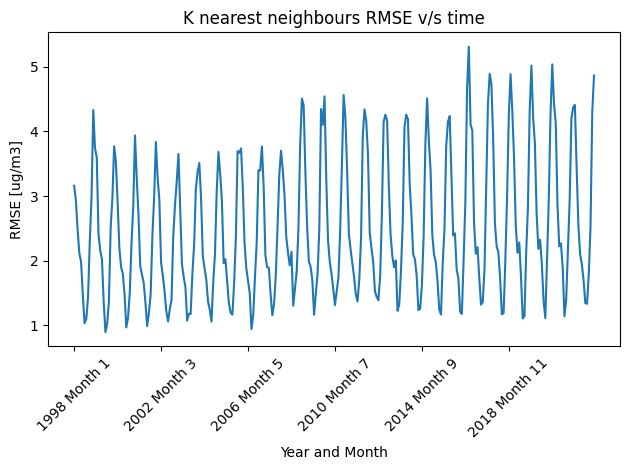

In [10]:
error_knn = np.zeros(300)

def train_and_compute_error(frame):
    X = X_train[frame]
    y = y_train[frame]
    reg = KNeighborsRegressor(n_neighbors=8).fit(X, y)
    predictions = reg.predict(X_test[frame])

    return np.sqrt(np.mean((predictions - y_test[frame]) ** 2))
    
for i in range(Timepoints):
    error_knn[i] = train_and_compute_error(i)

print_error(error_knn)
plot_error(error_knn, "K nearest neighbours RMSE v/s time", "RMSE [ug/m3]", 20)

#### Final Comparasions

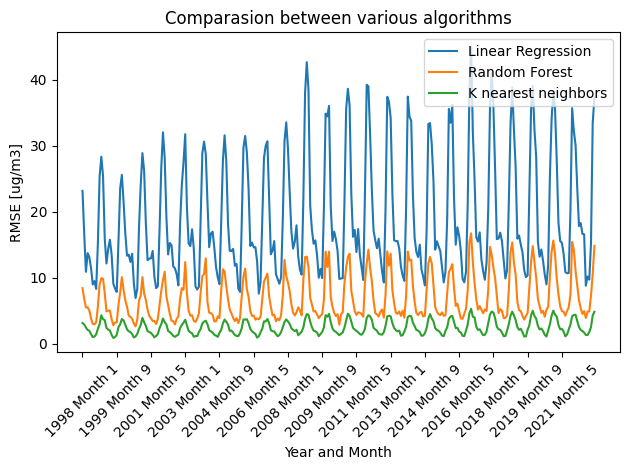

In [12]:
plt.figure()
[lr, rf, knn] = plt.plot(np.transpose([error_linear_regression, error_random_forest, error_knn]))
plt.legend([lr, rf, knn], ["Linear Regression",  "Random Forest", "K nearest neighbors"], loc=1)
plt.xticks(np.arange(0, len(error_linear_regression), 20), labels=[f"{1998 + int(frame / 12)} Month {frame % 12 + 1}" for frame in range(0, len(error_linear_regression), 20)], rotation=45)
plt.title("Comparasion between various algorithms")
plt.ylabel("RMSE [ug/m3]")
plt.xlabel("Year and Month")
plt.tight_layout()
plt.show()

## NO2 Data

#### Preparing the NO2 dataset for North America

In [7]:
files = ['NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_062021_V2.4_20240109.nc', # MonthYear
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_072021_V2.4_20240109.nc',
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_082021_V2.4_20240109.nc',
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_092021_V2.4_20240109.nc',
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_102021_V2.4_20240109.nc',
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_112021_V2.4_20240109.nc',
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_122021_V2.4_20240109.nc',
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_012022_V2.4_20240109.nc', 
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_022022_V2.4_20240109.nc', 
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_032022_V2.4_20240109.nc', 
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_042022_V2.4_20240109.nc', 
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_052022_V2.4_20240109.nc', 
         'NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_062022_V2.4_20240109.nc']

def get_data(fileName):
    nc = netCDF4.Dataset(fileName)
    data = nc.variables['Tropospheric_NO2'][::-1, :]
    lat = nc.variables['Latitude'][:]
    lon = nc.variables['Longitude'][:]
    lat_mask = (lat > 33.5) & (lat < 34.5) # latitude of Area around Los Angeles
    # lon_mask = (lon > -124.4333) & (lon < -114.1333) # longitude of California
    lon_mask = (lon > -118.5) & (lon < -117.5) # longitude of Area around Los Angeles
    lat = lat[lat_mask]
    lon = lon[lon_mask]
    data = data[lat_mask, :][:, lon_mask]
    for i, _lat in enumerate(lat):
        for j, _lon in enumerate(lon):
            coords = (_lat, _lon),
            obj = reverse_geocode.search(coords)
            if obj[0]['country'] != 'United States':
                data[i][j] = np.nan
            else:
                if obj[0]['city'] != 'Los Angeles' and obj[0]['city'] != 'Orange' and obj[0]['city'] != 'Ventura':
                    data[i][j] = np.nan
    return lat, lon, data

all_data = []

for fileName in files:
    print(fileName)
    lat, lon, data = get_data(fileName)
    all_data.append(data)

NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_062021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_072021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_082021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_092021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_102021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_112021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_122021_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_012022_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_022022_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_032022_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_042022_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_052022_V2.4_20240109.nc
NO2_Data/HAQ_TROPOMI_NO2_CONUS_QA75_L3_Monthly_062022_V2.4_20240109.nc


#### Preparing the PM2.5 Dataset for North America

In [8]:
def getNorthAmericaLatLon():
    data = getNorthAmericaPM25Data(Timestamp_Start)
    return data[0], data[1]

lat, lon = getNorthAmericaLatLon()

lat_mask = (lat > 33.5) & (lat < 34.5) # latitude of Area around Los Angeles
lon_mask = (lon > -118.5) & (lon < -117.5) # longitude of Area around Los Angeles

lat = lat[lat_mask]
lon = lon[lon_mask]
all_pm25_data = []
def readAndFormatData(fileIdx):
    data = getNorthAmericaPM25Data(fileIdx + Timestamp_Start)[2][lat_mask, :][:, lon_mask]
    for i, _lat in enumerate(lat):
        for j, _lon in enumerate(lon):
            coords = (_lat, _lon),
            obj = reverse_geocode.search(coords)

            if obj[0]['country'] != 'United States':
                data[i][j] = np.nan
            else:
                if obj[0]['city'] != 'Los Angeles' and obj[0]['city'] != 'Orange' and obj[0]['city'] != 'Ventura':
                    data[i][j] = np.nan

    return data

for i in range(12 + 1):
    all_pm25_data.append(readAndFormatData((2021 - 1998) * 12 + 5 + i))

### Animation

In [ ]:
%matplotlib tk

fig = plt.figure()
lat, lon, data = get_data(files[0])
im = plt.imshow(data)

def animation_fn(frame):
    im.set_array(all_data[frame])
    # im.axes.set_title(f"PM2.5 Monthly Mean [ug/m3]: Year {year} Month {int(month)}", fontsize=16)
    
    return [im]

anim = animation.FuncAnimation(fig, animation_fn, frames=len(files), interval=100)

plt.show()

### Average Monthly NO2 and PM2.5 plotted together
Here I plot the monthly average NO2 and PM2.5 data for Los Angels, Orange and Ventura

<Figure size 640x480 with 0 Axes>

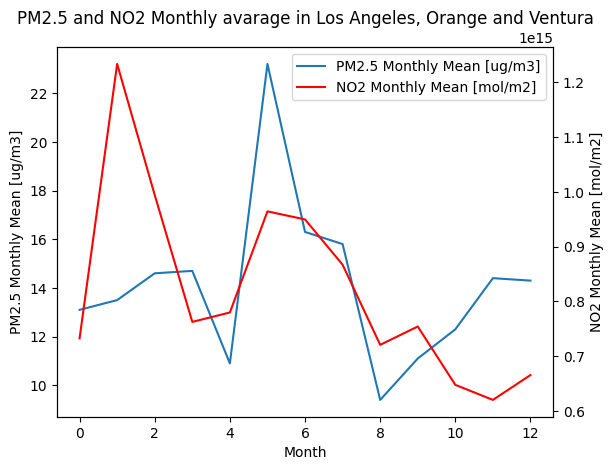

In [9]:
plt.figure()
fig, ax1 = plt.subplots()
l1 = ax1.plot([np.nanmean(i) for i in all_pm25_data], label="PM2.5 Monthly Mean [ug/m3]")
ax1.set_xlabel("Month")
ax1.set_ylabel("PM2.5 Monthly Mean [ug/m3]")
ax2 = ax1.twinx()

ax2.set_ylabel("NO2 Monthly Mean [mol/m2]")
l2 = ax2.plot([np.nanmean(i) for i in all_data], 'r', label="NO2 Monthly Mean [mol/m2]")

leg = l1 + l2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)

plt.title("PM2.5 and NO2 Monthly avarage in Los Angeles, Orange and Ventura")
plt.show()

## Correlation between boundry layer height and some other parameters (PM2.5, Temperature)
This is the plot of the boundary layer height data of the California region for the years 2021, 2022.

In [15]:
def getDatetimeObject(hours):
    return datetime.datetime.fromtimestamp(-2209008070 + hours * 60 * 60)

def getNumberofDays(month):
    if month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12:
        return 31
    if month == 2:
        return 28
    return 30

### PM2.5 and BLH

#### Preparing the dataset
PM2.5 Data for North America is taken from WUSTL

#### PM2.5 Data

In [10]:
lat, lon = getNorthAmericaLatLon()

lat_mask = (lat >= 32.53) & (lat <= 41.78) # latitude of Area around Los Angeles
lon_mask = (lon >= -124.4) & (lon <= -114.15) # longitude of Area around Los Angeles

lat = lat[lat_mask]
lon = lon[lon_mask]

def readAndFormatData(fileIdx):
    data = getNorthAmericaPM25Data(fileIdx + Timestamp_Start)[2][lat_mask, :][:, lon_mask]
    return data

pm25_data = []
for i in range(12 * 2):
    pm25_data.append(readAndFormatData((2021 - 1998) * 12 + i))

#### BLH Data

In [16]:
blh_data_hourly = []
blh_data_monthly = []
nc_file = netCDF4.Dataset("blh_data.nc")
lat = nc_file.variables['latitude'][:]
lon = nc_file.variables['longitude'][:]

for i, hours in enumerate(nc_file.variables['time']):
    current_data = nc_file.variables['blh'][i, :, :]
    
    blh_data_hourly.append(np.array([np.nanmean(current_data), hours]))
    
blh_data_hourly = np.array(blh_data_hourly)
    
done = 0
while done < len(blh_data_hourly):
    hours = 24 * getNumberofDays(i + 1)
    blh_data_monthly.append(np.nanmean(blh_data_hourly[done:done + hours, 0]))
    done += hours

#### Average Monthly BLH and PM2.5 Plotted together

<Figure size 640x480 with 0 Axes>

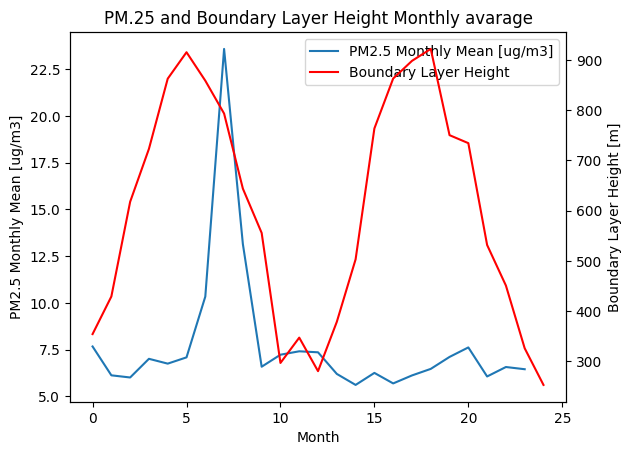

In [17]:
plt.figure()
fig, ax1 = plt.subplots()
l1 = ax1.plot([np.nanmean(i) for i in pm25_data], label="PM2.5 Monthly Mean [ug/m3]")
ax1.set_xlabel("Month")
ax1.set_ylabel("PM2.5 Monthly Mean [ug/m3]")
ax2 = ax1.twinx()

l2 = ax2.plot(blh_data_monthly, 'r', label="Boundary Layer Height")
ax2.set_ylabel("Boundary Layer Height [m]")

leg = l1 + l2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)

plt.title("PM.25 and Boundary Layer Height Monthly avarage")
plt.show()

### BLH over a few days

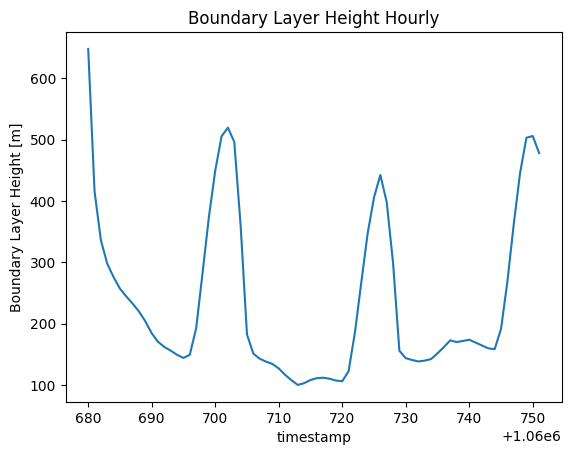

In [18]:
plt.plot(blh_data_hourly[:24 * 3, 1].astype('i'), blh_data_hourly[:24 * 3, 0])
plt.title("Boundary Layer Height Hourly")
plt.xlabel("timestamp")
plt.ylabel("Boundary Layer Height [m]")
plt.show()

### BLH correlation with temperature
The data for 2 metre temperature is taken from ERA's website

##### Preparing the dataset

In [19]:
temperature_data_hourly = []
nc_file = netCDF4.Dataset("temp_data.nc")
indexStart = 8784
for idx, current_data in enumerate(nc_file.variables['t2m'][indexStart:, 0, :, :]):
    try:
        temperature_data_hourly.append(np.array([np.nanmean(current_data), nc_file.variables['time'][indexStart + idx]]))
    except:
        pass
    
temperature_data_hourly = np.array(temperature_data_hourly)

##### Plot of BLH with temperature

<Figure size 640x480 with 0 Axes>

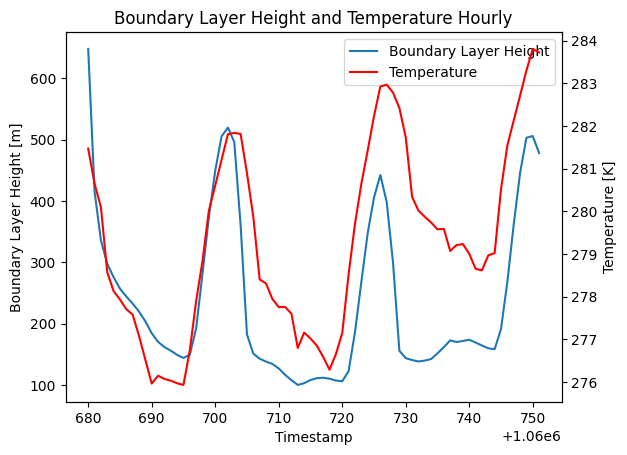

In [20]:
number_of_days = 3

plt.figure()
fig, ax1 = plt.subplots()
l1 = ax1.plot(blh_data_hourly[:24 * number_of_days, 1].astype('i'), blh_data_hourly[:24 * number_of_days, 0], label='Boundary Layer Height')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Boundary Layer Height [m]")
ax2 = ax1.twinx()

l2 = ax2.plot(temperature_data_hourly[:24 * number_of_days, 1].astype('i'), temperature_data_hourly[:24 * number_of_days, 0], 'r', label='Temperature')
ax2.set_ylabel("Temperature [K]")

leg = l1 + l2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)

plt.title("Boundary Layer Height and Temperature Hourly")
plt.show()

## References
1. Atmospheric Composition Analysis Group: https://sites.wustl.edu/acag/datasets/surface-pm2-5
2. Dataset: https://wustl.app.box.com/v/ACAG-V5GL04-GWRPM25c0p10/folder/237168822060
3. reverse_geocode: https://pypi.org/project/reverse-geocode/